## Neural Ordinary Differential Equations

### The Basics, (or what are ODEs and how do we solve them)

Ordinary differential equations are differential equations that only have one independent variable. For example

$$ \frac{dh}{dt} = \frac{3h}{2t} $$

In this case this can be solved analytically via separation of variables and integration.

$$ \int\frac{dh}{h} = \int\frac{3dt}{2t} $$
$$ ln(h) = \frac{3}{2}\ln(t) + c $$

Using our dear friend $e$

$$ h = Ct^{\frac{3}{2}} $$

Where C is a constant determined by the initial conditions.
We can also solve this problem numerically. To do this we follow the a path dicatated by $\frac{dh}{dt}$

Text(0.5, 0, 't')

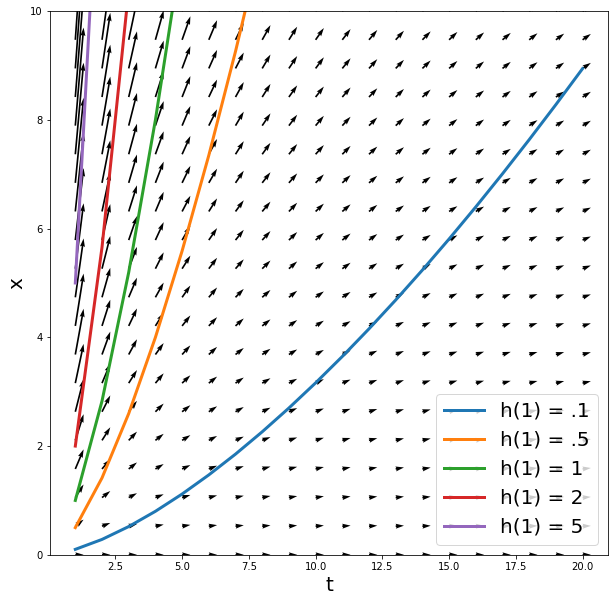

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dhdt(h, t):
    return 3.*h/(2.*t)

def analytic(t, C): #kind of nice, because initial conditions at t=1 C = x
    return C*t**(3./2)

h = np.linspace(0, 10, 20)
t = np.linspace(1, 20, 20)
tanalytic = np.linspace(1, 20, 20)
h, t = np.meshgrid(h,t)
changex = dhdt(h, t)
changey = np.ones(t.shape)
plt.figure(figsize = (10, 10))
plt.quiver(t, h, changey, changex)
plt.plot(tanalytic, analytic(tanalytic, .1), label = 'h(1) = .1', linewidth = 3)
plt.plot(tanalytic, analytic(tanalytic, .5), label = 'h(1) = .5', linewidth = 3)
plt.plot(tanalytic, analytic(tanalytic, 1), label = 'h(1) = 1', linewidth = 3)
plt.plot(tanalytic, analytic(tanalytic, 2), label = 'h(1) = 2', linewidth = 3)
plt.plot(tanalytic, analytic(tanalytic, 5), label = 'h(1) = 5', linewidth = 3)
plt.ylim(0,10)
plt.legend(fontsize = 20)
plt.ylabel('x', fontsize = 20)
plt.xlabel('t', fontsize = 20)

This plot shows the derivative at every point of h and t, and the analytic solutions show the exact path that would be  taken with initial conditions at h(1) and the given derivative. Note how different the solutions are based on what you're initial value of x is. The goal is to match these paths using a simulation that starts with an inital value of x and t and iterates forward in time. The simplest method is euler, which is simply a first order taylor expansion of the function around its current value.
$$ h(t+dt) = h(t) + \frac{dh}{dt}*\Delta t $$

Text(0.5, 0, 't')

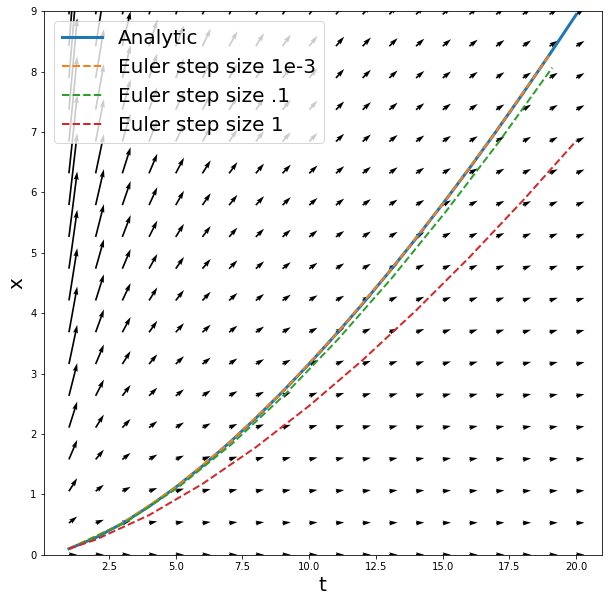

In [2]:
def euler(dhdt, h, t, dt):
    return h+dhdt(h, t)*dt

def ivpsolver(h0, dt, t0, tf, solver, derivative):
    hnew = h0
    tnew = t0
    
    ts = [t0]
    hs = [h0]
    steps = int(tf/dt)
    for i in range(steps):
        hnew = solver(dhdt, hnew, tnew, dt)
        tnew = tnew+dt
    
        if i%(steps/10) == 0:
            hs.append(hnew)
            ts.append(tnew)   
    return np.array(ts), np.array(hs)

plt.figure(figsize = (10, 10))
plt.quiver(t, h, changey, changex)
plt.plot(tanalytic, analytic(tanalytic, .1), label = 'Analytic', linewidth = 3)
t1, h1 = ivpsolver(.1, 1e-3, 1, 20, euler, dhdt)
plt.plot(t1, h1, '--', label = 'Euler step size 1e-3', linewidth = 2)
t1, h1 = ivpsolver(.1, .1, 1, 20, euler, dhdt)
plt.plot(t1, h1, '--', label = 'Euler step size .1', linewidth = 2)
t1, h1 = ivpsolver(.1, 1, 1, 20, euler, dhdt)
plt.plot(t1, h1,'--', label = 'Euler step size 1', linewidth = 2)
plt.ylim(0,9) 
plt.legend(fontsize = 20)
plt.ylabel('x', fontsize = 20)
plt.xlabel('t', fontsize = 20)

You can see that euler accumulates error at each step causing large step sizes to perform poorly, so small step sizes are needed to keep the solution from accumulating too much error. On the plus side, there has been 120 years of ODE solvers so we can do much better now. There now exist solvers with adaptive step sizes and error tolerances. This is good news, because when we have an equation like

$$ \frac{dh}{dt} = \frac{3h}{2t} + \frac{5h^2}{t^3} $$

This likely would be difficult (or not possible) to solve analytically, but can be solved numerically. In fact the sky is the limit (within reason) for defining the function $\frac{dh}{dt}$ for which we may be able to approximate our value h with.  

### How does this relate to machine learning?

Remember from (or maybe forget about) ResNet, where

$$ h_{t+1} = h_{t} + f(h_{t}, \theta) $$

NOTE: $h_t$ represents a discrete hidden layer, $h(t)$ represnets a continuous hidden layer

This stated that the next hidden layer was equal previous hidden layer plus a transformation of the previous hidden layer through some function. In this manner we could train deep neural networks effectively. In this case t is discrete, but what if we made t continuous (i.e. had infinite hidden layers)...

$$ \frac{dh(t)}{dt} = f(h(t), t, \theta) $$

That might look familiar. The hidden state can be thought of as continuously differentiable function. With

$$ h(t_0) = input $$

$$ h(T) = output $$

If it hasn't hit you yet, and what is so remarkable about this idea is that we have now changed the problem from learning a stack of complicated functions that describe the transformation of an input to an output (as we did with resnet) to learning a single function that describes the derivative hidden layers (intermediate values). The output of our network can be found via integration.

$$ h(t_0) + \int_{t=t_0}^{t=T} f(h(t), t, \theta) dt = h(T) $$

And this integration can be done with our handy ODE solver. 

Cool, but you probably have two questions:

### Show me something cool?
Be patient.

### How does it learn?

## The adjoint sensivity method

We need to train our network somehow. Naively you might suggest backpropogating through the ODE solver, but this accrues error into the system and storing derivative can be memory intensive. This is fine if the dynamics are relatively simple, and the network is small, but for more complicated problems the authors suggest the adjoint sensitivity method. 

What we want is to optimize a function that is the result of the ode solver. 

$$ L [h(T)] = L [h(t_0) + \int_{t=t_0}^{t=T} f(h(t), t, \theta) dt]  $$

We need to optimize L with respect to weghts $\theta$.

In a standard neural network

$$ \frac{dL}{dh_t} = \frac{dL}{dh_{t+1}}\frac{dh_{t+1}}{dh_t} $$

We can see that the loss gradient at a hidden layer in the network is the loss of the previous hidden layer times the gradient between the previous hidden layer and the current hidden layer. Once again we look for a continuous analog. 
First define the adjoint state at the hidden layer t

$$ a(t) = \frac{dL}{dh(t)}\,\,\,\, (1) $$

The derivative of this can be written 

$$ \frac{da(t)}{dt} = lim_{x\rightarrow 0} \frac{a(t+\epsilon) - a(t)}{\epsilon}\,\,\,\, (2)$$

Luckily we know via the chain rule that

$$ \frac{dL}{dh(t)} = \frac{dL}{dh(t+\epsilon)}\frac{dh(t+\epsilon)}{dh(t)} = a(t+\epsilon)\frac{dh(t+\epsilon)}{dh(t)} \,\,\,\, (3)$$

If we take the taylor expansion of $h(t+\epsilon)$

$$ h(t+\epsilon) = h(t) + \epsilon*f(h(t), t, \theta) + O(\epsilon^2) \,\,\,\, (4)$$

Substitute into 1, 3, and 4 into 2 and simplify to obtain

$$ \frac{da(t)}{dt} = -a(t)\frac{\partial f(h(t),t,\theta)}{\partial h(t)} $$

Now we have an ODE that defines our loss gradient with respect to our hidden state in our network. There are two more variables in our network though, $\theta$ and $t$.

This argument above holds for the other parameters, but since $\theta$ is independent of the hidden layer, and the change in the hidden layer with repect to its self is constant, the resulting Jacobian only contains three terms, which are the gradients of the dynamics function with respect to each variable. This results in three ODEs that are solved on the backwards pass. 

$$ \frac{da_{aug}(t)}{dt} = -[a_h \frac{\partial f}{\partial h}\,, a_h \frac{\partial f}{\partial \theta}\,, a_h \frac{\partial f}{\partial t}] $$

Where $a_h$ is the loss gradient with respect to the hidden state, AND $a_{aug}$ are the loss gradients with repect to the hidden state, the parameters, and t.

## Now lets see how this works on a toy example 

### Learning the velocity of a falling object

If you recall from your intro physcis class, the velocity of a falling ball at some time with quadratic drag is given by, 
$$ \frac{dv}{dt} = \theta_1 + \theta_2 v^{2} $$

This is simply newtons law stating that the change velocity with respect to time is given by the the the graviational constant minus some constant times the square fo the velocity. 

Lets say we have some noisy observations, and we want to find the dynamics function that describes the velocity.

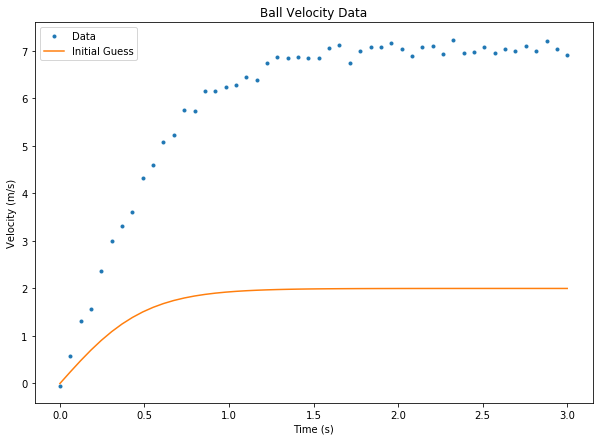

In [12]:
from scipy.integrate import odeint #This will solve our ode's with a high degree of precision
import numpy as np
import matplotlib.pyplot as plt

def dvdt(h, t, thetas): # velocity of the falling baseball from newton
    return thetas[0] + thetas[1] * h**2

times = np.linspace(0, 3, 50) #We haave 50 observations from our inital state
true_thetas = [10, -.2] #The dynamics parameters for our generated data
initial_velocity = 0 #The initial condition of our velocity

out = odeint(dvdt, initial_velocity, times, (true_thetas,)) #Integrate our dynamics function outputting at each time
vel_train = out[:,0]
vel_train = vel_train + np.random.randn(vel_train.size)/10.

guess_thetas = [4., -1.] #let's make an inital guess as to what the dynmaics parameters might be

out = odeint(dvdt, initial_velocity, times, (guess_thetas,))
vel_guess = out[:,0]

plt.figure(figsize =(10,7))
plt.plot(times, vel_train, '.', label = 'Data') #plot the data and the inital guess
plt.plot(times, vel_guess, label = 'Initial Guess')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ball Velocity Data')
plt.legend()

The adjoint state derivatives gives the loss gradient at any point in the network. This problem has no explicit dependance on t which simplifies it a bit. 

$$ \frac{da_{\theta}(t)}{dt} = -a_{v}(t)\frac{\partial f(v(t),\theta)}{\partial \theta} $$

$$ a_{\theta}(t) = \frac{dL}{d\theta} $$

We have two parameters so we need to solve two odes. $ \frac{\partial f(v(t),\theta)}{\partial \theta} $ can be derived from our equation for $f = \frac{dv}{dt}$ above.

$$ \frac{da_{\theta}(t)}{dt} = -a_{v}(t) $$

$$ \frac{da_{\theta}(t)}{dt} = -a_{v}(t)*v(t)^2 $$

But in order to solve this equation we also need 

$$ \frac{da_{v}(t)}{dt} = -a_{v}(t)\frac{\partial f(v(t),t,\theta)}{\partial v(t)} $$

But since our data is fairly closely spaced, we can assume the the adjoint velocity gradient is constant at each ovservation.

$$ a_{v}(t) = \frac{dL}{dv(t)} = 2*(v -v_{obs})$$

So to solve this problem, we need to obtain the cumulative loss gradient with respect to the parameters. To do this we integrate backward through the network. This means that we integrate the adjoint equations for theta between each observation. At each observation, we need to update the adjoint state for the velocity. The other subtlety is that we also need to reinitialize the adjoint state for the parameters to zero at each observation. This is because an infinitesimal change to the parameters at this point will not change the ouput enough to affect the total loss. (in other words, you are not likely to move from 1 to 2 in a single infinitesimal step with slighly tweaked parameters. 


[4.0, -1.0]
Model Params =  [array([4.01263853]), array([-0.95308163])] Actual Params =  [10, -0.2]
Model Params =  [array([7.97865029]), array([-0.12590679])] Actual Params =  [10, -0.2]
Model Params =  [array([8.81874887]), array([-0.1686057])] Actual Params =  [10, -0.2]
Model Params =  [array([9.21303058]), array([-0.17871514])] Actual Params =  [10, -0.2]


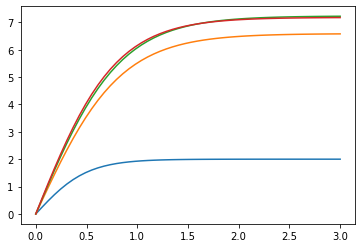

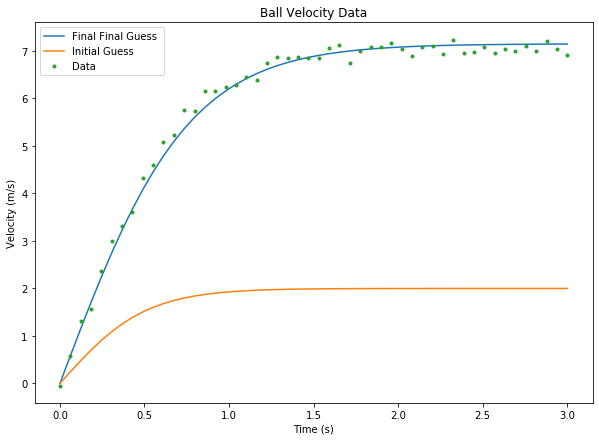

In [13]:
class fallingvelocity():
    
    def __init__(self, observations, thetas, times):
        
        self.observations = observations #our observation velocity
        self.thetas = thetas  #list of initial params must have opposite signs!
        self.times = times #our observation times
        
        
    def _dvdt(self, v, t, thetas): ### velocity of the falling baseball from newton
        return self.thetas[0] + self.thetas[1] * v**2

    def _adjointodetheta1(self, v, t, v_comp, Lossgrad): #adjoint ODE for the first parameter
        return -Lossgrad                          
    
    def _adjointodetheta2(self, v, t, v_comp, Lossgrad): #adjoint ODE for the second parameter
        return -Lossgrad * v_comp**2
    
    def adjoint(self, output):
    
        Lossgrad = 2*(output-self.observations) #square error loss gradient at every observation point
        
        timeback = self.times[::-1] #since we are integrating backwards through the network
        
        backsum1 = 0. #This will contain the cumulative loss with respect to parameter 1
        
        backsum2 = 0. #This will contain the cumulative loss with respect to parameter 1
    
        for i in range(len(self.times)-1): #Solve odes between each datapoint
            
            Lossg = Lossgrad[-(i+1)] #Loss gradient to initalize at given observation
            
            initial1 = 0.0 #initial condition for the weight gradient
            initial2 = 0.0 #initial condition for the weight gradient
            
            
            ## Here is where we integrate backwards through the network
            backward = odeint(self._adjointodetheta1, initial1, timeback[i:(i+2)], (output[-(i+1)], Lossg))
            backsum1 += backward[-1] #add this to your loss gradient wrt parameter 1 to get cumulative gradient

            ## Same for parameter 2
            backward2 = odeint(self._adjointodetheta2, initial2, timeback[i:(i+2)], (output[-(i+1)], Lossg))
            backsum2 += backward2[-1]
            
        return backsum1, backsum2
    
    def forward(self):
    
        out = odeint(self._dvdt, 0, self.times, (self.thetas,)) #Forward pass integration to obtain velocities
        
        out = out[:,0]
        
        return out #return velocities
    
model = fallingvelocity(vel_train, [4., -1.], times)

eps = .0005 #breaks pretty easily, be careful here
print(model.thetas)

for i in range(10000):

    output = model.forward()
    
    gradt1, gradt2 = model.adjoint(output)
    
    model.thetas[0] -= gradt1*eps
    model.thetas[1] -= gradt2*eps
    

    if i%2500 == 0:
        print('Model Params = ', model.thetas, 'Actual Params = ', true_thetas) 
        plt.plot(times, output, label = 'Final Guess '+str(i)) 

## The model learns to fit the data by solving an ode and seeing how well it does. Pretty neat right? 
plt.figure(figsize =(10,7))
plt.plot(times, output, label = 'Final Final Guess ')
plt.plot(times, vel_guess, label = 'Initial Guess')       
plt.plot(times, vel_train, '.', label = 'Data')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ball Velocity Data')
plt.legend()